In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import datasets, layers, models
from IPython import display
import mlcTest as mt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,sys
import scipy.io as sc
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import time
from IPython.display import clear_output
import math


def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(1, 50, 2)))
    model.add(layers.MaxPooling2D((1, 1)))
    model.add(layers.Conv2D(64, (1, 1), activation='relu'))
    model.add(layers.MaxPooling2D((1, 1)))
    model.add(layers.Conv2D(64, (1, 1), activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Reshape((50, 2, 1)))
    model.add(layers.Conv2D(64, (2, 1), strides=(1, 1), padding='same',
                                     input_shape=[1, 50, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def identity_loss(real, fake):
    loss = tf.reduce_mean(tf.abs(real - fake))
    return LAMBDA * 0.5 * loss


@tf.function
def train_step(total, label, noise):
    with tf.GradientTape(persistent=True) as tape:
        s = generator_s(total, training=True)
        n = generator_n(total, training=True)
        i = generator_i(s, training=True)
        gen = (s + n + i)
        fake_t = discriminator_t(gen, training=True)
        real_t = discriminator_t(total, training=True)
        gen_loss = generator_loss(fake_t)
        fake_d = discriminator_d(s, training=True)
        real_d = discriminator_d(label, training=True)
        gen_s_loss = generator_loss(fake_d)
        disc_t_loss = discriminator_loss(real_t, fake_t)
        disc_d_loss = discriminator_loss(real_d, fake_d)
        identity_s_loss = identity_loss(label, s)
        identity_g_loss = identity_loss(total, gen)
        identity_n_loss = identity_loss(noise, n)
        total_gen_loss = 1/2 * gen_s_loss + gen_loss
        total_s_loss = identity_g_loss + identity_s_loss + total_gen_loss
        total_n_loss = identity_n_loss + total_gen_loss
        total_i_loss = identity_g_loss + total_gen_loss

    gradients_of_s_generator = tape.gradient(total_s_loss, generator_s.trainable_variables)
    gradients_of_i_generator = tape.gradient(total_i_loss, generator_i.trainable_variables)
    gradients_of_n_generator = tape.gradient(total_n_loss, generator_n.trainable_variables)
    gradients_of_discriminator_t = tape.gradient(disc_t_loss, discriminator_t.trainable_variables)
    gradients_of_discriminator_d = tape.gradient(disc_d_loss, discriminator_d.trainable_variables)
    generator_s_optimizer.apply_gradients(zip(gradients_of_s_generator, generator_s.trainable_variables))
    generator_i_optimizer.apply_gradients(zip(gradients_of_i_generator, generator_i.trainable_variables))
    generator_n_optimizer.apply_gradients(zip(gradients_of_n_generator, generator_n.trainable_variables))
    discriminator_t_optimizer.apply_gradients(zip(gradients_of_discriminator_t, discriminator_t.trainable_variables))
    discriminator_d_optimizer.apply_gradients(zip(gradients_of_discriminator_d, discriminator_d.trainable_variables))

def shuffle_data(my_table):
    '''
    real_y = (2*my_table.real.min())/(my_table.real.max() - my_table.real.min()) + 1
    real_x = (my_table.real.max()) / (1 + real_y)
    imag_y = (2*my_table.imag.min())/(my_table.imag.max() - my_table.imag.min()) + 1
    imag_x = (my_table.imag.max()) / (1 + imag_y)
    my_table.real = (my_table.real / real_x) - real_y
    my_table.imag = (my_table.imag/ imag_x) - imag_y
    '''
    train_feature = my_table.loc[:, ('real', 'imag')]
    train_label = my_table.loc[:, ('label_real', 'label_imag')]
    noise = my_table.loc[:, ('N_R', 'N_I')]
    test_feature = tf.cast(train_feature, tf.float32)
    test_label = tf.cast(train_label, tf.float32)
    test_noise = tf.cast(noise, tf.float32)
    block = int(test_feature.shape[0]/50)
    test_feature = tf.reshape(test_feature,(block,1,50,2))
    test_label = tf.reshape(test_label, (block,1,50,2))
    symbol = my_table.loc[:, 'label']
    symbol = tf.reshape(symbol, (block,1, 50))
    return test_feature, test_label, symbol, test_noise 

generator_s = make_generator()
generator_n = make_generator()
generator_i = make_generator()
discriminator_t = make_discriminator_model()
discriminator_d = make_discriminator_model()


generator_s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_n_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_i_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/method8"
ckpt = tf.train.Checkpoint(generator_s=generator_s,
                           generator_n=generator_n,
                           generator_i=generator_i,
                           discriminator_t=discriminator_t,
                           discriminator_d=discriminator_d,
                           generator_s_optimizer=generator_s_optimizer,
                           generator_n_optimizer=generator_n_optimizer,
                           generator_i_optimizer=generator_i_optimizer,
                           discriminator_d_optimizer=discriminator_d_optimizer,
                           discriminator_t_optimizer=discriminator_t_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
LAMBDA = 10
EPOCHS = 500

Latest checkpoint restored!!


NameError: name 'dataset' is not defined

In [35]:
def dataset(dataFile, labelFile):
    dataFile = "../ML_Symbol_Gen-main/" + dataFile
    labelFile = "../ML_Symbol_Gen-main/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    label = my_labels['L_S_x']
    label_real = my_labels['X'].real
    label_imag = my_labels['X'].imag
    noise = my_labels['N']
    interference = my_labels['L_Interference'][0]
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X, interference, noise,
                       label_real, label_imag)
    mytable = assign_label(myOrig)
    return mytable


def assign_label(data):
    myTest = data.copy()
    myTest.loc[myTest.cons == 2, 'label'] = myTest.loc[myTest.cons == 2, 'label'] + 4
    myTest.label = myTest.label - 1
    return myTest


def table_data(my_data, cons, label, interference, noise, label_real, label_imag):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size, )
    label_real = label_real.T.reshape(my_data_size, )
    label_imag = label_imag.T.reshape(my_data_size, )
    noise = noise.T.reshape(my_data_size, )
    cons_array = np.array([[cons[i]] * my_data.shape[0] for i in range(0, block)]).reshape(my_data_size, )
    block_array = np.array([([i + 1] * my_data.shape[0]) for i in range(0, block)]).reshape(my_data_size, )
    interference_array = np.array([[interference[i]] * my_data.shape[0]
                               for i in range(0, block)]).reshape(my_data_size, )
    label_array = label.T.reshape(my_data_size, )
    test_pd = pd.DataFrame({'real': my_data_div.real, 'imag': my_data_div.imag,
                            'cons': cons_array, 'block': block_array,
                            'label': label_array,
                           'interference':interference_array,
                           'N_R': noise.real, 'N_I':noise.imag,
                           'label_real': label_real, 'label_imag':label_imag})
    return test_pd

LAMBDA = 10
EPOCHS = 500
data1 = "my_data"
data1_label = "my_labels"
data = dataset(data1, data1_label)
file_directory = './result/tes2/'
f, l, s, n = shuffle_data(data)
l

<tf.Tensor: shape=(1000, 1, 50, 2), dtype=float32, numpy=
array([[[[-0.31622776,  0.31622776],
         [-0.9486833 ,  0.31622776],
         [ 0.9486833 , -0.31622776],
         ...,
         [-0.9486833 ,  0.9486833 ],
         [ 0.9486833 , -0.9486833 ],
         [-0.9486833 , -0.31622776]]],


       [[[ 0.31622776,  0.9486833 ],
         [-0.31622776,  0.31622776],
         [ 0.31622776,  0.31622776],
         ...,
         [-0.31622776,  0.31622776],
         [-0.9486833 ,  0.31622776],
         [ 0.31622776, -0.31622776]]],


       [[[ 0.70710677,  0.70710677],
         [-0.70710677,  0.70710677],
         [ 0.70710677, -0.70710677],
         ...,
         [-0.70710677,  0.70710677],
         [-0.70710677, -0.70710677],
         [-0.70710677, -0.70710677]]],


       ...,


       [[[ 0.9486833 ,  0.9486833 ],
         [ 0.31622776, -0.9486833 ],
         [ 0.9486833 , -0.31622776],
         ...,
         [ 0.9486833 ,  0.31622776],
         [-0.9486833 ,  0.9486833 ],
         

In [34]:
labelFile = "my_labels"
labelFile = "../ML_Symbol_Gen-main/" + labelFile
my_labels = sc.loadmat(labelFile)
X = my_labels['L_S_x']
number = my_labels['X']
number.real.T.reshape(50000,) - data.label_real

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
49995    0.0
49996    0.0
49997    0.0
49998    0.0
49999    0.0
Name: label_real, Length: 50000, dtype: float64

In [24]:
X.real

array([[ 6,  3,  2, ...,  4, 16,  2],
       [ 5,  6,  1, ..., 15,  1,  4],
       [12,  7,  4, ..., 12,  7,  4],
       ...,
       [ 1,  6,  1, ...,  8,  1,  2],
       [16,  5,  3, ...,  1,  9,  3],
       [ 9, 11,  3, ...,  8,  5,  3]], dtype=uint8)

In [4]:
sample = data
train_set = mt.training_set(sample)
test_set = mt.test_set(sample, train_set)

In [5]:
r_f, r_l, r_s = shuffle_data(train_set)
t_f, t_l, t_s = shuffle_data(test_set)

/Users/donhomlee/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
def clssification():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (1, 1), activation='relu', input_shape=(1, 50, 2)))
    model.add(layers.MaxPooling2D(1,1))
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(1,1))
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(1,1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(20))
    return model

In [7]:
cnn = clssification()
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 50, 16)         48        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 50, 16)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 50, 32)         4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 50, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 50, 64)         18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 50, 64)         0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 50, 64)        

In [8]:
fake_f = generator_s(r_f)
fake_f

<tf.Tensor: shape=(808, 1, 50, 2), dtype=float32, numpy=
array([[[[-0.6594234 , -0.7975002 ],
         [ 0.6286454 , -0.6889707 ],
         [-0.6857938 , -0.65785116],
         ...,
         [ 0.6693846 , -0.22004925],
         [-0.13673826,  0.5776159 ],
         [ 1.0257151 ,  0.15171495]]],


       [[[ 0.704278  ,  0.13928056],
         [ 0.31896147,  0.23410471],
         [-1.0103995 , -1.0168939 ],
         ...,
         [ 0.02996268,  1.0474498 ],
         [ 0.7298288 ,  0.17488264],
         [-0.8254614 , -1.0340794 ]]],


       [[[ 0.7510183 ,  0.4857117 ],
         [ 0.84766   , -0.8559601 ],
         [ 0.7472061 , -0.664995  ],
         ...,
         [ 0.8798021 ,  0.7709963 ],
         [-0.6056517 ,  0.79505527],
         [ 0.6346717 , -0.64536303]]],


       ...,


       [[[ 0.9956228 , -0.9741407 ],
         [ 0.901085  ,  0.69243294],
         [ 0.7307038 , -0.10965825],
         ...,
         [ 0.9732502 , -0.9035409 ],
         [-0.28957632,  1.0236644 ],
         [

In [17]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = cnn.fit(fake_f, r_s, epochs=100, verbose=0,
                    validation_data=(fake_f,r_s))

In [18]:
history.history

{'loss': [0.49320465326309204,
  0.3907756209373474,
  0.3671855628490448,
  0.40505698323249817,
  0.3757922351360321,
  0.35846132040023804,
  0.37284693121910095,
  0.3619661331176758,
  0.3655417561531067,
  0.3659214973449707,
  0.3619604706764221,
  0.36056020855903625,
  0.36314478516578674,
  0.3742782771587372,
  0.3743170201778412,
  0.36227357387542725,
  0.35661008954048157,
  0.37548747658729553,
  0.40515461564064026,
  0.3621320128440857,
  0.36272940039634705,
  0.3588038980960846,
  0.35875698924064636,
  0.3699432909488678,
  0.36316540837287903,
  0.3630506992340088,
  0.3744758665561676,
  0.3572536110877991,
  0.3580641746520996,
  0.3904202878475189,
  0.35762321949005127,
  0.3598683178424835,
  0.3481391668319702,
  0.36150726675987244,
  0.3772057592868805,
  0.36129987239837646,
  0.3529394567012787,
  0.3444209694862366,
  0.3402656316757202,
  0.34374338388442993,
  0.35948121547698975,
  0.36410513520240784,
  0.3439705967903137,
  0.3509903848171234,
  0.3

In [19]:
test_f = generator_s(t_f)

In [20]:
cnn.evaluate(test_f, t_s, verbose=0)

[0.43159446120262146, 0.8353124856948853]

In [21]:
probability_model = tf.keras.Sequential([cnn, tf.keras.layers.Softmax()])

In [22]:
predictions = probability_model.predict(test_f)

In [23]:
predictions.shape

(192, 1, 50, 20)

In [24]:
test = predictions.reshape(9600,20)
test = mt.get_results(test)
label = t_s.numpy().reshape(9600,)

In [25]:
compare_set = test_set.copy()
compare_set['prediction'] = test

In [26]:
compare_set.to_csv('./test_result.csv',index=False)

In [52]:
cf = tf.math.confusion_matrix(test, label).numpy()
cf = pd.DataFrame(cf)

In [5]:
cf

NameError: name 'cf' is not defined

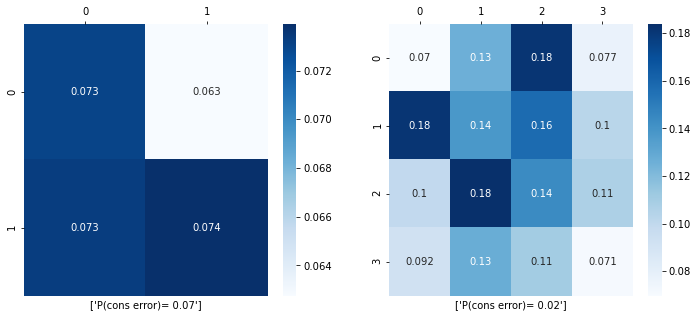

In [56]:
mt.divide_Result(cf, 'test', "3")

In [59]:
data = pd.read_csv("./test2.csv")

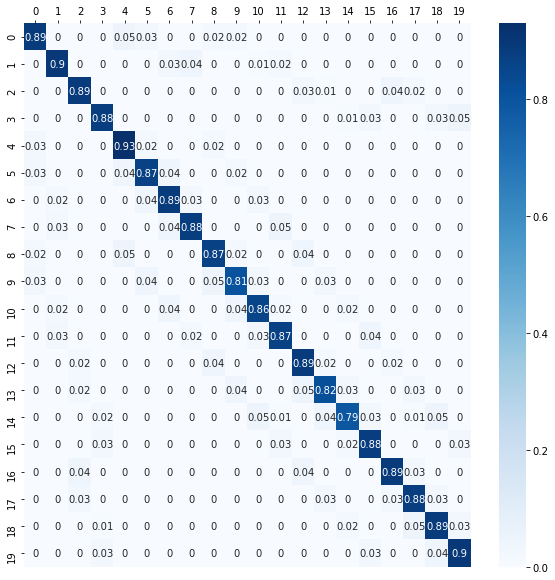

In [71]:
import seaborn as sns
fig, ax2 = plt.subplots(1, figsize=(10, 10))
df = sns.heatmap(data, annot=True,cmap=plt.cm.Blues, ax=ax2)
df.xaxis.tick_top()
fig.savefig("./test4", dpi=500)

In [6]:
mean_abs_loss = tf.keras.losses.MeanAbsoluteError()

In [24]:
def noise_loss(noise_output):
    return mean_abs_loss(0, noise_output).numpy()

In [51]:
dataFile = "my_data"
labelFile = "my_labels"
dataFile = "../ML_Symbol_Gen-main/" + dataFile
labelFile = "../ML_Symbol_Gen-main/" + labelFile
my_data = sc.loadmat(dataFile)
my_labels = sc.loadmat(labelFile)

In [52]:
interference = my_labels['L_Interference'][0]
my_data = my_data['Y']
block = my_data.shape[1]
my_data_size = my_data.shape[0] * block

In [53]:
interference_array = np.array([[interference[i]] * my_data.shape[0] 
                               for i in range(0, block)]).reshape(my_data_size, )

In [54]:
interference_array

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [23]:
def dataset(dataFile, labelFile):
    dataFile = "../ML_Symbol_Gen-main/" + dataFile
    labelFile = "../ML_Symbol_Gen-main/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    X = my_labels['L_S_x']
    interference = my_labels['L_Interference'][0]
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X, interference)
    mytable = assign_label(myOrig)
    return mytable


def assign_label(data):
    c_4 = [1,-1]
    c_16 = [3,1,-1,-3]
    c_16r = [-3,-1,1,3]
    cons_4 = np.dot(np.sqrt(0.5),[complex(i,j)for i in c_4 for j in c_4])
    cons_16 = np.array([complex(i,j)for j in c_16 for i in c_16r])
    cons_16 = cons_16/np.sqrt(np.mean(np.abs(cons_16)**2))
    cons4 = data[data.cons==1]
    cons4_label = np.array([[cons_4[i-1]]for i in cons4.label])
    cons16 = data[data.cons==2]
    cons16_label = np.array([[cons_16[i-1]]for i in cons16.label.to_numpy().real.astype(int)])
    data[data.cons==2].index
    data['buffer'] = 0
    data['buffer'] = 0
    data.iloc[data[data.cons==1].index, 6] = cons4_label
    data.iloc[data[data.cons==2].index, 6] = cons16_label
    data['label_real'] = data.buffer.to_numpy().real
    data['label_imag'] = data.buffer.to_numpy().imag
    myTest = data.copy()
    myTest.loc[myTest.cons == 2, 'label'] = myTest.loc[myTest.cons == 2, 'label'] + 4
    myTest.label = myTest.label - 1
    return myTest


def table_data(my_data, cons, label, interference):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size, )
    cons_array = np.array([[cons[i]] * my_data.shape[0] for i in range(0, block)]).reshape(my_data_size, )
    block_array = np.array([([i + 1] * my_data.shape[0]) for i in range(0, block)]).reshape(my_data_size, )
    interference_array = np.array([[interference[i]] * my_data.shape[0] 
                               for i in range(0, block)]).reshape(my_data_size, )
    label_array = label.T.reshape(my_data_size, )
    test_pd = pd.DataFrame({'real': my_data_div.real, 'imag': my_data_div.imag,
                            'cons': cons_array, 'block': block_array,
                            'label': label_array,
                           'interference':interference_array})
    return test_pd

In [24]:
data1 = "my_data"
data1_label = "my_labels"
data = dataset(data1, data1_label)

In [25]:
data

,real,imag,cons,block,label,interference,buffer,label_real,label_imag
0,0.149470,0.132843,2,1,10,1,0.316228+0.316228j,0.316228,0.316228
1,-0.082554,0.181870,2,1,9,1,-0.316228+0.316228j,-0.316228,0.316228
2,0.674836,-1.251851,2,1,19,1,0.948683-0.948683j,0.948683,-0.948683
3,0.749973,-0.228798,2,1,15,1,0.948683-0.316228j,0.948683,-0.316228
4,0.586466,0.628398,2,1,10,1,0.316228+0.316228j,0.316228,0.316228
...,...,...,...,...,...,...,...,...,...
49995,0.672681,-0.794178,1,1000,3,0,-0.707107-0.707107j,-0.707107,-0.707107
49996,0.719018,0.728860,1,1000,1,0,0.707107-0.707107j,0.707107,-0.707107
49997,-0.699735,0.665377,1,1000,0,0,0.707107+0.707107j,0.707107,0.707107
49998,0.778618,-0.738863,1,1000,3,0,-0.707107-0.707107j,-0.707107,-0.707107


In [3]:
def dataset(dataFile, labelFile):
    dataFile = "../ML_Symbol_Gen-main/" + dataFile
    labelFile = "../ML_Symbol_Gen-main/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    X = my_labels['L_S_x']
    interference = my_labels['L_Interference'][0]
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X, interference)
    mytable = assign_label(myOrig)
    return mytable


def assign_label(data):
    c_4 = [1,-1]
    c_16 = [3,1,-1,-3]
    c_16r = [-3,-1,1,3]
    cons_4 = np.dot(np.sqrt(0.5),[complex(i,j)for i in c_4 for j in c_4])
    cons_16 = np.array([complex(i,j)for j in c_16 for i in c_16r])
    cons_16 = cons_16/np.sqrt(np.mean(np.abs(cons_16)**2))
    cons4 = data[data.cons==1]
    cons4_label = np.array([[cons_4[i-1]]for i in cons4.label])
    cons16 = data[data.cons==2]
    cons16_label = np.array([[cons_16[i-1]]for i in cons16.label.to_numpy().real.astype(int)])
    data[data.cons==2].index
    data['buffer'] = 0
    data['buffer'] = 0
    data.iloc[data[data.cons==1].index, 6] = cons4_label
    data.iloc[data[data.cons==2].index, 6] = cons16_label
    data['label_real'] = data.buffer.to_numpy().real
    data['label_imag'] = data.buffer.to_numpy().imag
    myTest = data.copy()
    myTest.loc[myTest.cons == 2, 'label'] = myTest.loc[myTest.cons == 2, 'label'] + 4
    myTest.label = myTest.label - 1
    return myTest


def table_data(my_data, cons, label, interference):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size, )
    cons_array = np.array([[cons[i]] * my_data.shape[0] for i in range(0, block)]).reshape(my_data_size, )
    block_array = np.array([([i + 1] * my_data.shape[0]) for i in range(0, block)]).reshape(my_data_size, )
    interference_array = np.array([[interference[i]] * my_data.shape[0] 
                               for i in range(0, block)]).reshape(my_data_size, )
    label_array = label.T.reshape(my_data_size, )
    test_pd = pd.DataFrame({'real': my_data_div.real, 'imag': my_data_div.imag,
                            'cons': cons_array, 'block': block_array,
                            'label': label_array,
                           'interference':interference_array})
    return test_pd

In [13]:
data

,real,imag,cons,block,label,interference,N_R,N_I,buffer,label_real,label_imag
0,0.120629,0.086947,2,1,10,1,0.056849,0.040222,0.316228+0.316228j,0.316228,0.316228
1,-0.038891,0.120501,2,1,9,1,0.010067,0.089249,-0.316228+0.316228j,-0.316228,0.316228
2,0.481826,-0.860746,2,1,19,1,-0.050240,-0.079561,0.948683-0.948683j,0.948683,-0.948683
3,0.533483,-0.160562,2,1,15,1,0.024896,-0.136177,0.948683-0.316228j,0.948683,-0.316228
4,0.421070,0.426108,2,1,10,1,0.046632,0.088564,0.316228+0.316228j,0.316228,0.316228
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.480344,-0.547511,1,1000,3,0,-0.034426,-0.087071,-0.707107-0.707107j,-0.707107,-0.707107
49996,0.512201,0.494865,1,1000,1,0,0.011912,0.021753,0.707107-0.707107j,0.707107,-0.707107
49997,-0.463211,0.451417,1,1000,0,0,0.007372,-0.041730,0.707107+0.707107j,0.707107,0.707107
49998,0.553177,-0.509653,1,1000,3,0,0.071511,-0.031756,-0.707107-0.707107j,-0.707107,-0.707107


In [11]:
my_label['N'].shape

(50, 1000)